# Adapted from <https://computing.llnl.gov/projects/zfp/zfp-and-derivatives>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
x = y = np.linspace(-1, 1, 1024)
Y, X = np.meshgrid(y, x, indexing="ij")

In [3]:
dx = x[1] - x[0]
dy = y[1] - y[0]
dy, dx

(np.float64(0.0019550342130987275), np.float64(0.0019550342130987275))

In [4]:
U = np.power(X**2 + Y**2, 3 / 2) / 9

In [5]:
DU = np.sqrt(X**2 + Y**2)

In [6]:
def plot_DU(DU):
    fig, ax = plt.subplots()

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    im = ax.imshow(DU, cmap="RdBu_r", origin="lower", extent=(-1, 1, -1, 1))
    ax.contour(X, Y, DU, levels=10, colors="lightgrey", alpha=0.25)
    ax.set_aspect("equal")

    fig.colorbar(im, cax=cax, orientation="vertical")

    plt.show()

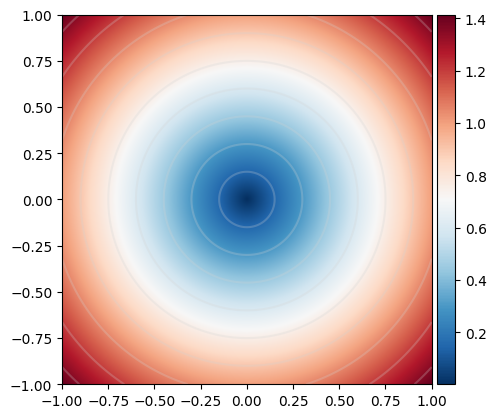

In [7]:
plot_DU(DU)

In [8]:
DU_np = np.gradient(np.gradient(U, axis=0), axis=0) / (dy * dy) + np.gradient(
    np.gradient(U, axis=1), axis=1
) / (dx * dx)

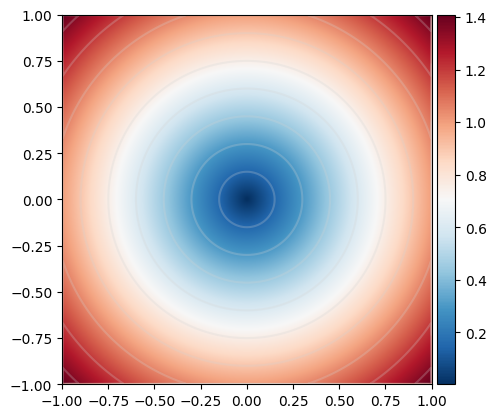

In [9]:
plot_DU(DU_np)

In [10]:
from numcodecs_wasm_zfp import Zfp

In [11]:
zfp = Zfp(mode="fixed-rate", rate=5.5)

In [12]:
U_zfp = zfp.decode(zfp.encode(U))

In [13]:
DU_zfp = np.gradient(np.gradient(U_zfp, axis=0), axis=0) / (dy * dy) + np.gradient(
    np.gradient(U_zfp, axis=1), axis=1
) / (dx * dx)

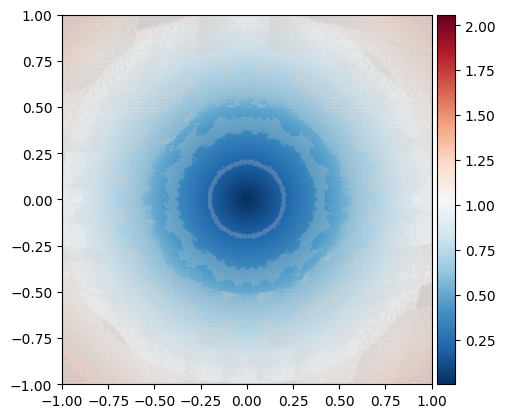

In [14]:
plot_DU(DU_zfp)

In [15]:
print("err_abs:", np.amax(np.abs(U_zfp - U)))
print("err_abs_qoi:", np.amax(np.abs(DU_zfp - DU_np)))

err_abs: 3.36917364224254e-06
err_abs_qoi: 0.870952738655759


In [16]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

In [17]:
sg = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(kind="eb", type="abs", eb=3e-6),
    ],
)

In [18]:
U_sg = sg.decode(sg.encode(U))

In [19]:
DU_sg = np.gradient(np.gradient(U_sg, axis=0), axis=0) / (dy * dy) + np.gradient(
    np.gradient(U_sg, axis=1), axis=1
) / (dx * dx)

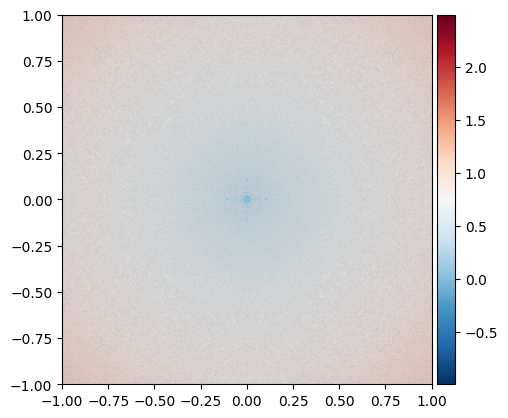

In [20]:
plot_DU(DU_sg)

In [21]:
print("err_abs:", np.amax(np.abs(U_sg - U)))
print("err_abs_qoi:", np.amax(np.abs(DU_sg - DU_np)))

err_abs: 2.9999626987147485e-06
err_abs_qoi: 1.5324086517186184


In [22]:
sg_qoi = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(
            kind="qoi_eb_stencil",
            qoi="finite_difference(x, order=2, accuracy=2, type=0, axis=0, grid_spacing=2/1023)+finite_difference(x, order=2, accuracy=2, type=0, axis=1, grid_spacing=2/1023)",
            neighbourhood=[
                dict(axis=0, before=1, after=1, boundary="edge"),
                dict(axis=1, before=1, after=1, boundary="edge"),
            ],
            type="abs",
            eb=0.1,
        ),
    ],
)

In [23]:
sg_qoi._safeguards.safeguards[0]._qoi_expr

1046529*X[0, 1]/4 + 1046529*X[1, 0]/4 - 1046529*X[1, 1] + 1046529*X[1, 2]/4 + 1046529*X[2, 1]/4

In [24]:
U_sg_qoi = sg_qoi.decode(sg_qoi.encode(U))

In [25]:
DU_sg_qoi = np.gradient(np.gradient(U_sg_qoi, axis=0), axis=0) / (
    dy * dy
) + np.gradient(np.gradient(U_sg_qoi, axis=1), axis=1) / (dx * dx)

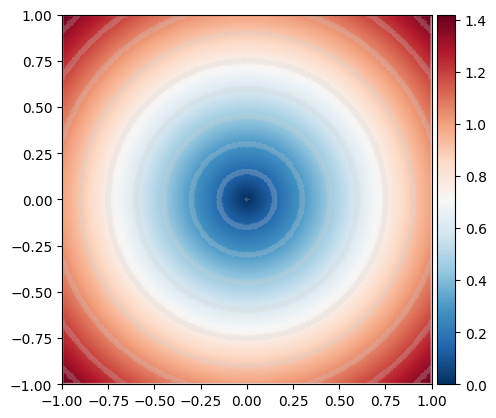

In [26]:
plot_DU(DU_sg_qoi)

In [27]:
print("err_abs:", np.amax(np.abs(U_sg_qoi - U)))
print("err_abs_qoi:", np.amax(np.abs(DU_sg_qoi - DU_np)))

err_abs: 4.777682890977353e-08
err_abs_qoi: 0.025951887971075838


In [28]:
U = np.exp(4 * X + 3 * Y)

In [29]:
DU = U * 25

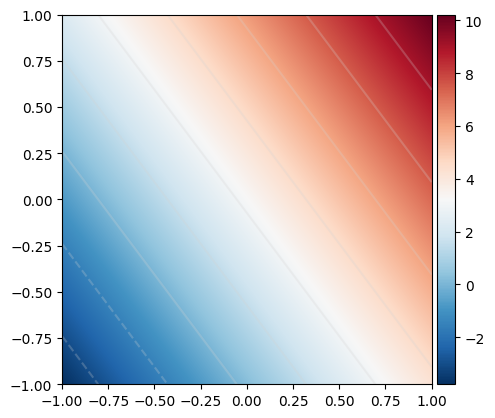

In [30]:
plot_DU(np.log(DU))

In [31]:
DU_np = np.gradient(np.gradient(U, axis=0), axis=0) / (dy * dy) + np.gradient(
    np.gradient(U, axis=1), axis=1
) / (dx * dx)

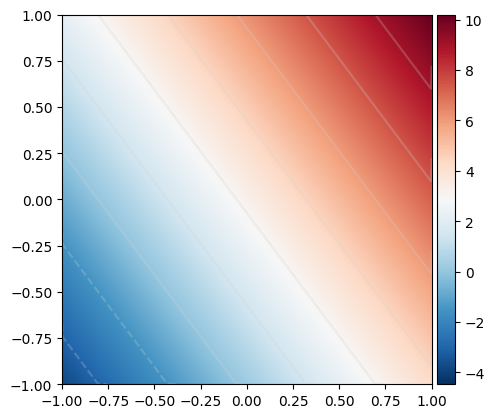

In [32]:
plot_DU(np.log(DU_np))

In [33]:
zfp = Zfp(mode="fixed-rate", rate=5.5)

In [34]:
U_zfp = zfp.decode(zfp.encode(U))

In [35]:
DU_zfp = np.gradient(np.gradient(U_zfp, axis=0), axis=0) / (dy * dy) + np.gradient(
    np.gradient(U_zfp, axis=1), axis=1
) / (dx * dx)

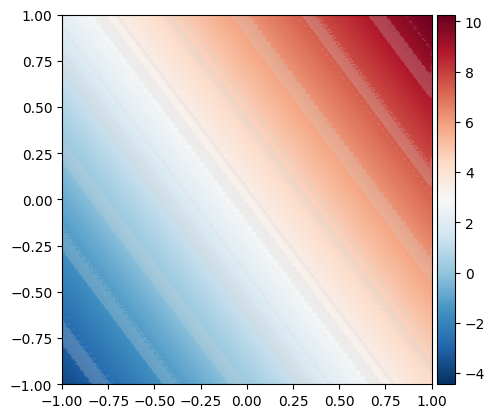

In [36]:
plot_DU(np.log(DU_zfp))

In [37]:
print("err_abs:", np.amax(np.abs(U_zfp - U)))
print("err_abs_qoi:", np.amax(np.abs(np.log(DU_zfp) - np.log(DU_np))))

err_abs: 0.0315610340890089
err_abs_qoi: 0.8225278340356992


In [38]:
sg = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(kind="eb", type="abs", eb=0.03),
    ],
)

In [39]:
U_sg = sg.decode(sg.encode(U))

In [40]:
DU_sg = np.gradient(np.gradient(U_sg, axis=0), axis=0) / (dy * dy) + np.gradient(
    np.gradient(U_sg, axis=1), axis=1
) / (dx * dx)

/tmp/ipykernel_19518/4048621075.py:1: RuntimeWarning: divide by zero encountered in log
  plot_DU(np.log(DU_sg))
/tmp/ipykernel_19518/4048621075.py:1: RuntimeWarning: invalid value encountered in log
  plot_DU(np.log(DU_sg))


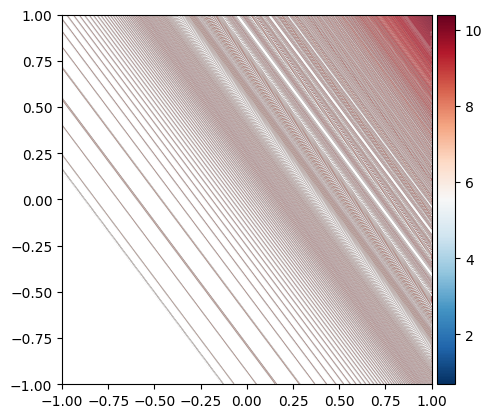

In [41]:
plot_DU(np.log(DU_sg))

In [42]:
print("err_abs:", np.amax(np.abs(U_sg - U)))
print("err_abs_qoi:", np.nanmax(np.abs(np.log(DU_sg) - np.log(DU_np))))

err_abs: 0.029995941885815114
err_abs_qoi: inf


/tmp/ipykernel_19518/503299091.py:2: RuntimeWarning: divide by zero encountered in log
  print("err_abs_qoi:", np.nanmax(np.abs(np.log(DU_sg) - np.log(DU_np))))
/tmp/ipykernel_19518/503299091.py:2: RuntimeWarning: invalid value encountered in log
  print("err_abs_qoi:", np.nanmax(np.abs(np.log(DU_sg) - np.log(DU_np))))


In [43]:
sg_qoi = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(
            kind="qoi_eb_stencil",
            qoi="ln(finite_difference(x, order=2, accuracy=2, type=0, axis=0, grid_spacing=2/1023)+finite_difference(x, order=2, accuracy=2, type=0, axis=1, grid_spacing=2/1023))",
            neighbourhood=[
                dict(axis=0, before=1, after=1, boundary="edge"),
                dict(axis=1, before=1, after=1, boundary="edge"),
            ],
            type="abs",
            eb=1.0,
        ),
    ],
)

In [44]:
sg_qoi._safeguards.safeguards[0]._qoi_expr

log(1046529*X[0, 1]/4 + 1046529*X[1, 0]/4 - 1046529*X[1, 1] + 1046529*X[1, 2]/4 + 1046529*X[2, 1]/4)

In [45]:
U_sg_qoi = sg_qoi.decode(sg_qoi.encode(U))

In [46]:
DU_sg_qoi = np.gradient(np.gradient(U_sg_qoi, axis=0), axis=0) / (
    dy * dy
) + np.gradient(np.gradient(U_sg_qoi, axis=1), axis=1) / (dx * dx)

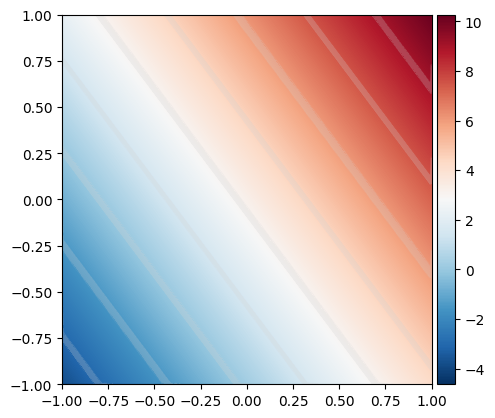

In [47]:
plot_DU(np.log(DU_sg_qoi))

In [48]:
print("err_abs:", np.amax(np.abs(U_sg_qoi - U)))
print("err_abs_qoi:", np.amax(np.abs(np.log(DU_sg_qoi) - np.log(DU_np))))

err_abs: 0.007540173442293963
err_abs_qoi: 0.2287810334197511
